# Sparse GP benchmarks

Sparse GP benchmarks for 'Kernels with Latent Gaussian Processes for Non-stationary Regression' paper.
Here we train and evaluate GPs with the following kernels
- Squared exponemtial
- Squared exponemtial times periodic plus squared exponential (custom kernel)

In [1]:
%set_env CUDA_VISIBLE_DEVICES=0

import torch
import tqdm
import gpytorch
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution
from gpytorch.distributions import MultivariateNormal
from gpytorch.models import ApproximateGP, GP
from gpytorch.mlls import VariationalELBO, AddedLossTerm
from gpytorch.likelihoods import GaussianLikelihood

env: CUDA_VISIBLE_DEVICES=0


In [2]:
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP
from gpytorch.mlls import DeepApproximateMLL

In [3]:
import urllib.request
import os
import numpy as np
from math import floor
import pandas as pd

In [4]:
import sgpr as sgpr

# Load data

In [5]:
data_df = pd.read_csv('khyber_2000_2010_tp.csv')

In [8]:
data = torch.Tensor(data_df.values)
X = data[:, 1:-1]
X = X - X.min(0)[0]
X = 2 * (X / X.max(0)[0]) - 1
y = data[:, -1]

In [9]:
train_n = int(floor(0.8 * len(X)))
train_x = X[:train_n, :].contiguous()
train_y = y[:train_n].contiguous()

test_x = X[train_n:, :].contiguous()
test_y = y[train_n:].contiguous()

In [10]:
if torch.cuda.is_available():
    train_x, train_y, test_x, test_y = train_x.cuda(), train_y.cuda(), test_x.cuda(), test_y.cuda()

In [11]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

In [12]:
# Inducing points
idx = np.random.randint(len(train_x), size=400)
Z_init = train_x[idx]

## Sparse GP 

In [13]:
# Kernels
SE_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=3))
custom_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=3) + gpytorch.kernels.RBFKernel(ard_num_dims=1, active_dims=[0])* gpytorch.kernels.PeriodicKernel(active_dims=[0]))

In [16]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = sgpr.SparseGPR(train_x, train_y, likelihood, Z_init, custom_kernel)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

## Training

In [ ]:
# Train:
losses = model.train_model(optimizer, max_steps=1000)

Iter 1/1000 - Loss: 3.582   outputscale: 1.324  lengthscale: None   noise: 0.693 
Iter 51/1000 - Loss: 2.810   outputscale: 1.672  lengthscale: None   noise: 0.950 


## Metrics

In [57]:
import matplotlib.pyplot as plt

In [ ]:
from metrics import rmse, nlpd

In [25]:
## predictions
test_pred = model.posterior_predictive(test_x)

In [ ]:
rmse_test = np.round(rmse(test_pred.loc, test_y).item(), 4)
nlpd_test = np.round(nlpd(test_pred, test_y).item(), 4)

In [53]:
d = test_x[19:]

In [66]:
a = test_y[19:]

In [71]:
pred = model.posterior_predictive(d[::43])

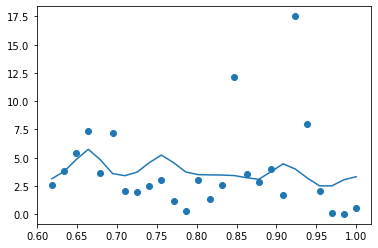

In [72]:
plt.plot(d[::43, 0], pred.loc)
plt.scatter(d[::43, 0], a[::43])

In [73]:
d[::43, 0]

tensor([0.6183, 0.6336, 0.6488, 0.6641, 0.6794, 0.6946, 0.7099, 0.7252, 0.7404,
        0.7557, 0.7710, 0.7862, 0.8015, 0.8168, 0.8320, 0.8473, 0.8626, 0.8778,
        0.8931, 0.9084, 0.9236, 0.9389, 0.9542, 0.9695, 0.9847, 1.0000])